In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

assert torch.cuda.is_available()

In [15]:
DEP_COL = "_HYPNO-mode"

# Utility functions to load in the data
dataset = np.load("sc-agg-f16-veryhighdim.npz")

# Create a reproducible sample of rows from the given set
def generate_sample(size_per, set_name="train_patients", random_state=42):
    # Set up the random state & the row storage
    r = np.random.RandomState(random_state)
    rows = []

    # Loop through each person in the named set and select that number of rows, randomly
    for entry in dataset[set_name]:
        entry_set = dataset[entry]
        to_get = size_per if type(size_per) is int else int(size_per * entry_set.shape[0])
        selection = r.choice(range(entry_set.shape[0]), size=to_get, replace=False)
        rows.extend(entry_set[selection])

    # Return the sample and the labels
    return np.array(rows, dtype=float), dataset["labels"]

# Convert a sample to X and y pairs, with numeric values in the place of NaNs
def to_xy_numeric(sample, labels):
    dep_col_idx = np.where(labels == DEP_COL)[0]
    X = np.delete(sample, dep_col_idx, axis=1)
    y = sample[:, dep_col_idx]
    y[np.isnan(y)] = 6
    return X, y

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.,),(1.,))])
def to_torch_data(X, y):
    y = y.ravel()
    
    y_enc = np.zeros((y.size, int(y.max() + 1)), dtype=int)
    y_enc[np.arange(y.size), y.astype(int)] = 1
    
    entries = []
    for row, y_enc_part in zip(X, y_enc):
        entries.append([transform(row.reshape((-1, 1))).to(torch.float32), torch.from_numpy(y_enc_part).to(torch.float32)])
    
    return entries

In [16]:
# Create the device variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA: ", "Yes" if torch.cuda.is_available() else "No")

# Load the training & data set
train_data = to_torch_data(*to_xy_numeric(*generate_sample(1., random_state=1919)))
validate_data = to_torch_data(*to_xy_numeric(*generate_sample(1., set_name="validate_patients", random_state=456)))
test_data = to_torch_data(*to_xy_numeric(*generate_sample(1., set_name="test_patients", random_state=456)))

CUDA:  Yes


In [17]:
# Create the data loaders
train_ldr = DataLoader(train_data, batch_size=128, shuffle=True)
validate_ldr = DataLoader(validate_data, batch_size=32, shuffle=False)
test_ldr = DataLoader(test_data, batch_size=32, shuffle=False)

In [19]:
class NNConvo(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(in_features=467, out_features=128)
        self.a1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.l2 = nn.Linear(in_features=128, out_features=128)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(in_features=128, out_features=32)
        self.a3 = nn.ReLU()
        self.l4 = nn.Linear(in_features=32, out_features=7)
        
    def forward(self, x):
        return self.l4(self.a3(self.l3(self.a2(self.l2(self.dropout2(self.a1(self.l1(self.flatten(x)))))))))
    
model = NNConvo()
model(train_data[0][0])

print("Number of Parameters:", sum([p.numel() for p in filter(lambda p: p.requires_grad, model.parameters())]))

Number of Parameters: 80775


In [20]:
num_epochs = 50

model = model.to(device)

objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=1e-5, nesterov=True)

# Store details about epochs
epoch_loss = []
epoch_val_loss = []
epoch_acc = []

# Set up the loop
loop = tqdm(total=(len(train_ldr) + len(validate_ldr)) * num_epochs, position=0)
loss_list = []
validation_loss_list = []

highest = 0

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    for x, y_truth in train_ldr:
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Predict labels
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        
        # Calculate loss & back-propagate
        loss = objective(y_hat, y_truth)
        loss.backward()
        
        # Optimize & update weights
        optimizer.step()
        
        # Update the loop display
        loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
        loop.update()
        
        # Save the loss
        loss_list.append(loss.item())
    
    # Save the loss mean
    epoch_loss.append(np.mean(loss_list))
    loss_list = []
    
    # Compute validation accuracy
    model.eval()
    validation_score = 0
    for x, y_truth in validate_ldr:
        # Move to device
        x, y_truth = x.to(device), y_truth.to(device)
        
        # Make prediction
        y_hat = model(x)
        
        # Compute validation loss
        validation_loss = objective(y_hat, y_truth).item()
        validation_loss_list.append(validation_loss)
        
        # calculate accuracy
        validation_score += sum(torch.eq(y_truth.argmax(1), y_hat.argmax(1))) / len(x)
        
        # Update loop display
        loop.set_description('epoch:{}, validation:{:.4f}...'.format(epoch, validation_loss))
        loop.update()
    epoch_val_loss.append(np.mean(validation_loss_list))
    validation_loss_list = []
    epoch_acc.append(validation_score.item() / len(validate_ldr))
    
    if epoch_acc[-1] > highest:
        torch.save(model.state_dict(), f'saves/{epoch_acc[-1]}.ckpt')
        highest = epoch_acc[-1]

# Close the loop
loop.close()

epoch:49, validation:0.4718...: 100%|██████████| 207350/207350 [07:12<00:00, 479.01it/s] 


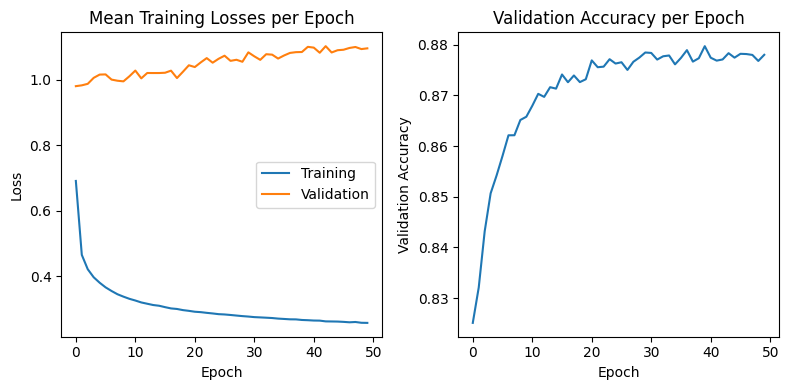

In [21]:
# Plot the mean losses and validation accuracies
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(epoch_loss, label="Training")
plt.plot(epoch_val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Mean Training Losses per Epoch")

plt.subplot(122)
plt.plot(epoch_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.tight_layout()
plt.show()

In [22]:
# Loop over all the test points
score = 0
for i, (x_orig, y_truth) in enumerate(test_ldr):
    # Move data to the GPU
    x_orig, y_truth = x_orig.to(device), y_truth.to(device)
    
    # Compute the perturbed image and store it if it is the first
    y_hat = model(x_orig.to(device))
    
    # Compute the test accuracy
    score += sum(torch.eq(y_truth.argmax(1), y_hat.argmax(1))) / len(x_orig)

# Print the accuracy
print("Overall Accuracy on Test Data:", score.item() / len(test_ldr))

Overall Accuracy on Test Data: 0.8776520726024037


In [23]:
# Load checkpoint
model.load_state_dict(torch.load("saves/0.878475892310049.ckpt"))

# Loop over all the test points
score = 0
for i, (x_orig, y_truth) in enumerate(test_ldr):
    # Move data to the GPU
    x_orig, y_truth = x_orig.to(device), y_truth.to(device)
    
    # Compute the perturbed image and store it if it is the first
    y_hat = model(x_orig.to(device))
    
    # Compute the test accuracy
    score += sum(torch.eq(y_truth.argmax(1), y_hat.argmax(1))) / len(x_orig)

# Print the accuracy
print("Overall Accuracy on Test Data:", score.item() / len(test_ldr))

Overall Accuracy on Test Data: 0.8753909124356144
